# 第8章 線形モデルの回帰分析



## 8.1 線形回帰



### 8.1.1 1次関数と回帰分析



リスト8.1: 線形回帰の概念を説明するための図を作成



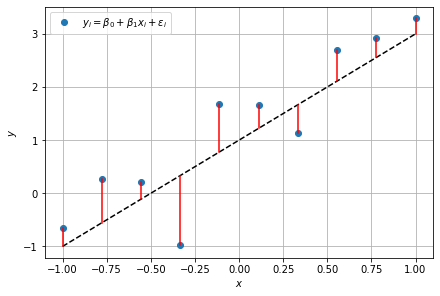

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# データ点の配列
x = np.linspace(-1, 1, 10)
rng = np.random.default_rng(1)
err = rng.normal(0, 1, size=len(x))
y = 1 + 2 * x + err
# 1次関数の配列
x_true = np.linspace(-1, 1, 100)
y_true = 1 + 2 * x_true

fig, ax = plt.subplots(constrained_layout=True)

ax.plot(x, y, 'o', 
        label=r'$y_i=\beta_0+\beta_1 x_i+\epsilon_i$')
ax.plot(x_true, y_true, 'k--')

# 誤差をプロット
for i in range(len(x)):
    ax.plot((x[i], x[i]), (y[i], 1 + 2 * x[i]), 'r')
    
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend()
ax.grid()

### 8.1.2 statsmodelsを用いた線形回帰



リスト8.2: statsmodelsからモジュールをインポート



In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

リスト8.3: `mtcars` データセットを読み込む



In [3]:
data = sm.datasets.get_rdataset('mtcars').data

リスト8.4: 読み込んだデータの内容を確認



In [4]:
data.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


リスト8.5: データを散布図で表示



Text(0, 0.5, 'mpg')

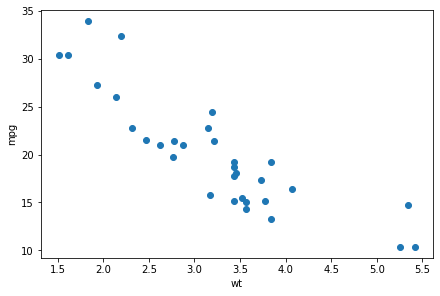

In [5]:
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(data['wt'], data['mpg'])
ax.set_xlabel('wt')
ax.set_ylabel('mpg')

リスト8.6: `ols` 関数を使用した線形回帰モデルの作成



In [6]:
model = smf.ols('mpg ~ wt', data=data)

リスト8.7: パラメータ推定の実行



In [7]:
result = model.fit()

リスト8.8: 推定結果の要約を表示



In [8]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     91.38
Date:                Tue, 15 Jun 2021   Prob (F-statistic):           1.29e-10
Time:                        16:15:58   Log-Likelihood:                -80.015
No. Observations:                  32   AIC:                             164.0
Df Residuals:                      30   BIC:                             167.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.2851      1.878     19.858      0.000      33.450      41.120
wt            -5.3445      0.559     -9.559      0.000      -6.486      -4.203
==============================================================================
Omnibus:                        2.988   Durbin-Watson:                   1.252
Prob(Omnibus):                  0.225   Jarque-Bera (JB):                2.399
Skew:                           0.668   Prob(JB):                        0.301
Kurtosis:                       2.877   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

リスト8.9: パラメータの推定値を確認



In [9]:
result.params

Intercept    37.285126
wt           -5.344472
dtype: float64

リスト8.10: 回帰直線を描画



Text(0, 0.5, 'mpg')

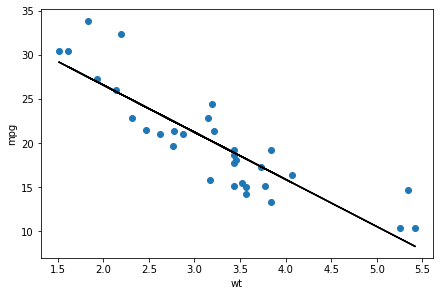

In [10]:
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(data['wt'], data['mpg'])
ax.plot(data.wt, result.fittedvalues, 'k')
ax.set_xlabel('wt')
ax.set_ylabel('mpg')

### 8.1.3 PyMC3による線形回帰



リスト8.11: 半正規分布におけるパラメータ $\sigma$ の影響



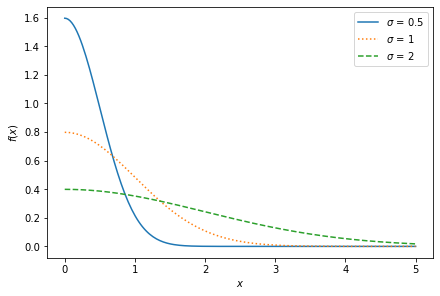

In [11]:
from scipy import stats

x = np.linspace(0, 5, 200)
sigmas = [0.5, 1, 2]
ls = ['-', ':', '--']

fig, ax = plt.subplots(constrained_layout=True)

for sigma, l in zip(sigmas, ls):
    pdf = stats.halfnorm.pdf(x, scale=sigma)
    ax.plot(x, pdf, l, label=rf'$\sigma$ = {sigma}')
    
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.legend()

リスト8.12: PyMC3のインポート



In [1]:
import pymc3 as pm
import warnings
warnings.simplefilter('ignore', FutureWarning)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


リスト8.13: 線形回帰モデルの定義方法



In [13]:
with pm.Model() as model:
    beta_0 = pm.Normal('beta_0', mu=0, sigma=100)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=100)
    epsilon = pm.HalfNormal('epsilon', sigma=5)    
    
    mu = pm.Deterministic('mu',
                          beta_0 + beta_1 * data['wt'])
    # mu の値をトレースに保存する必要がなければ以下のように書く
    # mu = beta_0 + beta_1 * data['wt']
    
    pm.Normal('y', mu=mu, sigma=epsilon, 
              observed=data['mpg'])

リスト8.14: モデルの数式表現を確認



In [14]:
model

リスト8.15: 観測データが設定されていない確率変数



In [15]:
model.free_RVs

[beta_0 ~ Normal, beta_1 ~ Normal, epsilon_log__ ~ TransformedDistribution]

リスト8.16: 観測データが設定されている確率変数



In [16]:
model.observed_RVs

[y ~ Normal]

リスト8.17: `deterministics` 属性の確認



In [17]:
model.deterministics

[epsilon ~ HalfNormal, mu ~ Deterministic]

リスト8.18: 事後分布をサンプリング



In [18]:
with model:
    trace = pm.sample(random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta_1, beta_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 142 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


リスト8.19: トレースプロットを表示



array([[<AxesSubplot:title={'center':'beta_0'}>,
        <AxesSubplot:title={'center':'beta_0'}>],
       [<AxesSubplot:title={'center':'beta_1'}>,
        <AxesSubplot:title={'center':'beta_1'}>],
       [<AxesSubplot:title={'center':'epsilon'}>,
        <AxesSubplot:title={'center':'epsilon'}>]], dtype=object)

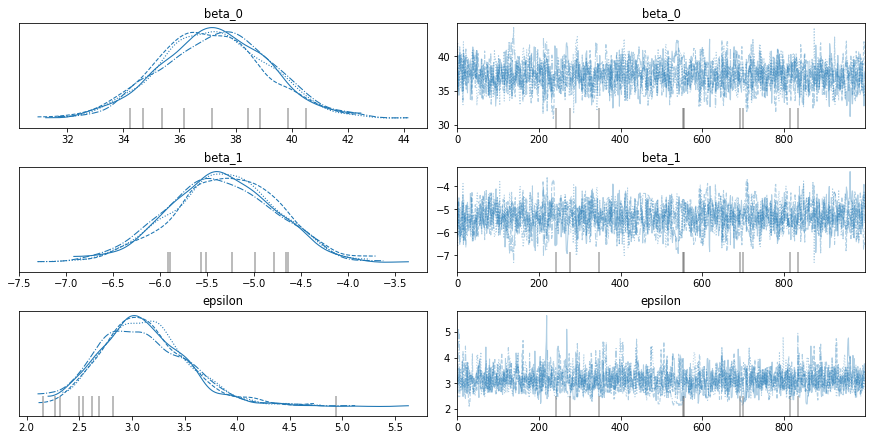

In [19]:
names = ['beta_0', 'beta_1', 'epsilon']
# names = '~mu' と指定することもできる

pm.plot_trace(trace, var_names=names)

リスト8.20: 要約統計量の確認



In [20]:
pm.summary(trace, var_names=names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,37.227,1.902,33.643,40.735,0.059,0.042,1043.0,1459.0,1.00
beta_1,-5.333,0.565,-6.368,-4.275,0.018,0.013,1020.0,1326.0,1.00
epsilon,3.121,0.428,2.409,3.968,0.013,0.009,943.0,460.0,1.01


リスト8.21: 自己相関の確認



array([<AxesSubplot:title={'center':'beta_0'}>,
       <AxesSubplot:title={'center':'beta_1'}>,
       <AxesSubplot:title={'center':'epsilon'}>], dtype=object)

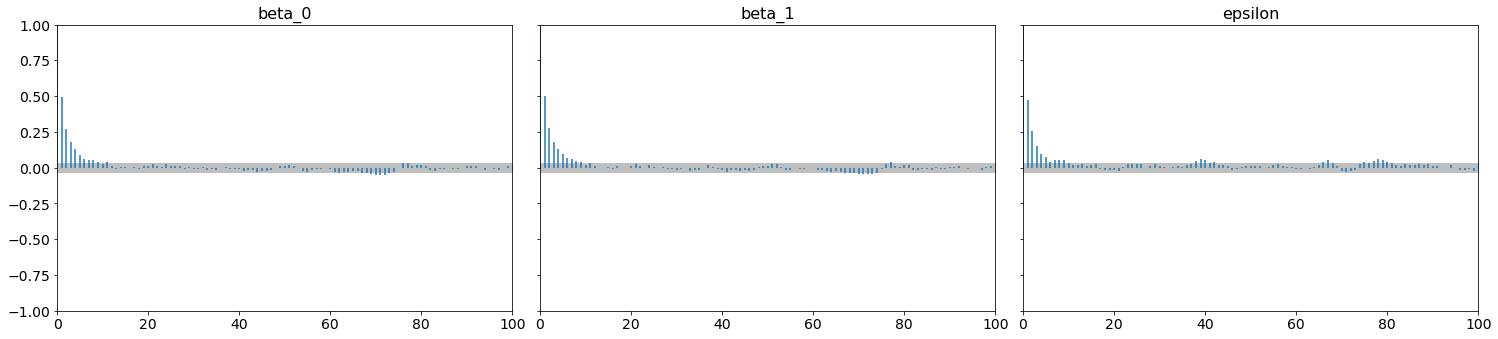

In [21]:
pm.plot_autocorr(trace, var_names=names, combined=True)

リスト8.22: データの中心化



In [22]:
data['wt_c'] = data['wt'] - data['wt'].mean()

リスト8.23: 中心化したデータを用いたモデル



In [23]:
with pm.Model() as model_c:
    beta_0 = pm.Normal('beta_0', mu=0, sigma=100)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=100)
    epsilon = pm.HalfNormal('epsilon', sigma=5)    
    
    mu = pm.Deterministic('mu', 
                          beta_0 + beta_1 * data['wt_c'])
    
    pm.Normal('mpg', mu=mu, sigma=epsilon, 
              observed=data['mpg'])

    trace_c = pm.sample(random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta_1, beta_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 132 seconds.


リスト8.24: 自己相関の確認



array([<AxesSubplot:title={'center':'beta_0'}>,
       <AxesSubplot:title={'center':'beta_1'}>,
       <AxesSubplot:title={'center':'epsilon'}>], dtype=object)

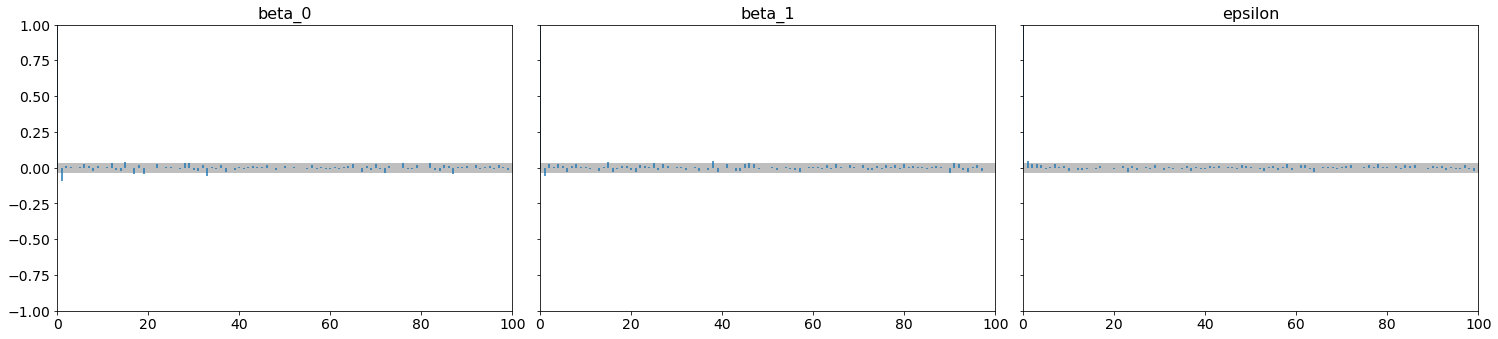

In [24]:
pm.plot_autocorr(trace_c, var_names=names,
                 combined=True)

リスト8.25: トレースプロットを表示



array([[<AxesSubplot:title={'center':'beta_0'}>,
        <AxesSubplot:title={'center':'beta_0'}>],
       [<AxesSubplot:title={'center':'beta_1'}>,
        <AxesSubplot:title={'center':'beta_1'}>],
       [<AxesSubplot:title={'center':'epsilon'}>,
        <AxesSubplot:title={'center':'epsilon'}>]], dtype=object)

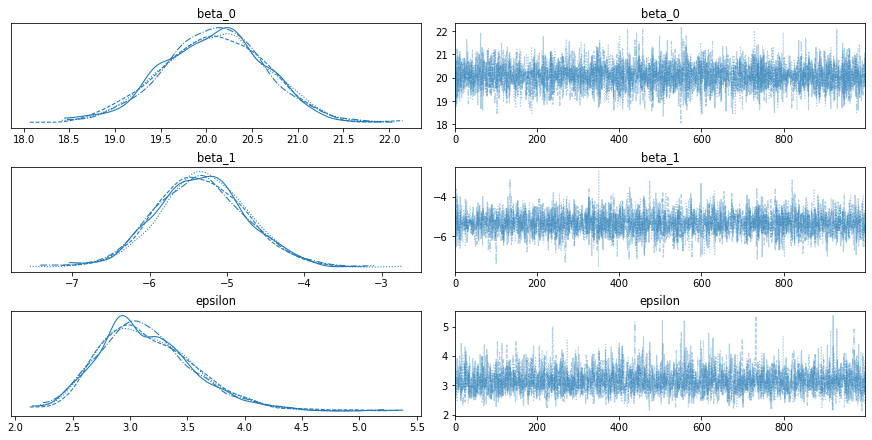

In [25]:
pm.plot_trace(trace_c, var_names=names)

リスト8.26: 要約統計量の確認



In [26]:
pm.summary(trace_c, var_names=names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,20.088,0.569,19.039,21.166,0.008,0.006,4752.0,2951.0,1.0
beta_1,-5.328,0.580,-6.338,-4.183,0.009,0.006,4119.0,2557.0,1.0
epsilon,3.153,0.427,2.382,3.930,0.008,0.005,3254.0,2397.0,1.0


リスト8.27: $\beta_0$ の推定値



In [27]:
beta_0 = trace_c['beta_0'] - trace_c['beta_1'] * data['wt'].mean()
beta_0.mean()

37.22889933860273

リスト8.28: 生成された乱数の配列の形状



In [28]:
trace_c['mu'].shape

(4000, 32)

リスト8.29: 回帰直線とその不確かさを図示



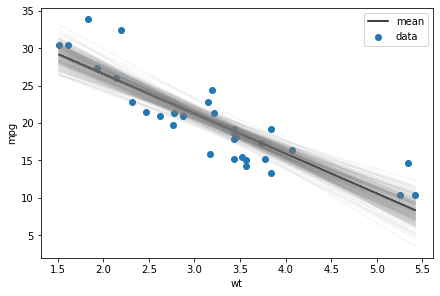

In [29]:
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(data['wt'], data.mpg, label='data')
ax.plot(data['wt'], trace_c['mu'].mean(axis=0), 
        'k', label='mean')

for i in range(0, len(trace_c['mu']), 20):
    ax.plot(data['wt'], trace_c['mu'][i, :], 
            'gray', alpha=0.05)

ax.set_xlabel('wt')
ax.set_ylabel('mpg')
ax.legend()

リスト8.30: 事後予測の乱数を生成



In [30]:
with model_c:
    pp = pm.sample_posterior_predictive(trace_c)

リスト8.31: 事後予測の配列の形状



In [31]:
pp['mpg'].shape

(4000, 32)

リスト8.32: 回帰直線のHDIを表示



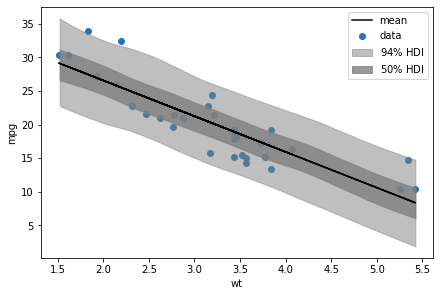

In [32]:
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(data['wt'], data['mpg'], label='data')
ax.plot(data['wt'], trace_c['mu'].mean(axis=0), 
        'k', label='mean')

pm.plot_hdi(data['wt'], pp['mpg'], ax=ax,
            fill_kwargs={'color': 'gray', 
                         'label': r'$94\%$ HDI'})
pm.plot_hdi(data['wt'], pp['mpg'], hdi_prob=0.5, ax=ax,
            fill_kwargs={'color': 'gray', 
                         'alpha': 0.8,
                         'label': r'$50\%$ HDI'})

ax.set_xlabel('wt')
ax.set_ylabel('mpg')
ax.legend()

## 8.2 ロバスト線形回帰



### 8.2.1 スチューデントのt分布



リスト8.33: 外れ値のあるデータセットの作成



In [3]:
import numpy as np

n = 30
x = np.linspace(-5, 5, n)

beta0_true = 2
beta1_true = 0.5
rng = np.random.default_rng(1)
err = rng.normal(0, 0.5, size=n)

y = beta0_true + beta1_true * x + err
y[-2] = 8
y[-4] = 10

data = {'x': x, 'y': y}

リスト8.34: データを散布図で表示



Text(0, 0.5, '$y$')

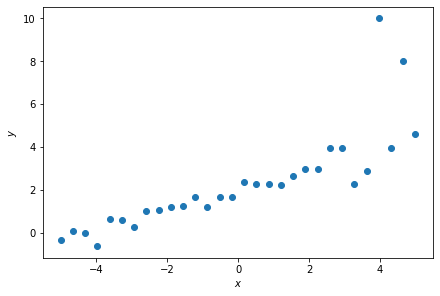

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(data['x'], data['y'])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

リスト8.35: データの箱ひげ図



{'whiskers': [<matplotlib.lines.Line2D at 0x2169b444520>,
 'caps': [<matplotlib.lines.Line2D at 0x2169b444b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x2169b4440d0>],
 'medians': [<matplotlib.lines.Line2D at 0x2169b44c2e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2169b44c670>],
 'means': []}

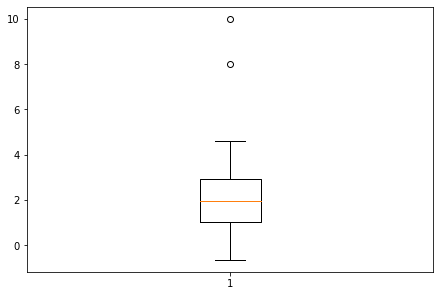

In [5]:
fig, ax = plt.subplots(constrained_layout=True)

ax.boxplot(data['y'])

リスト8.36: スチューデントのt分布におけるパラメータ $\nu$ の影響

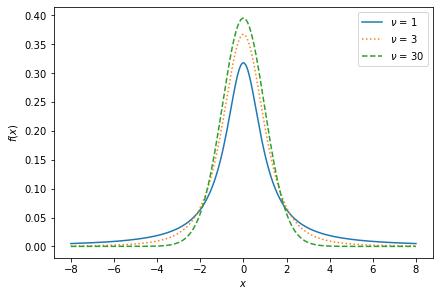

In [6]:
from scipy import stats

x = np.linspace(-8, 8, 200)
mu = 0
sigma = 1
nus = [1, 3, 30]
ls = ['-', ':', '--']

fig, ax = plt.subplots(constrained_layout=True)

for nu, l in zip(nus, ls):
    pdf = stats.t.pdf(x, nu, loc=mu, scale=sigma)
    ax.plot(x, pdf, l, label=rf'$\nu$ = {nu}')
    
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.legend()

### 8.2.2 ロバスト線形回帰



リスト8.37: 正規分布を用いた線形回帰モデルにおけるサンプリング



In [7]:
import pymc3 as pm
import warnings
warnings.simplefilter('ignore', FutureWarning)

with pm.Model() as model:
    beta0 = pm.Normal('beta0', mu=0, sigma=100)
    beta1 = pm.Normal('beta1', mu=0, sigma=100)
    epsilon = pm.HalfNormal('epsilon', sigma=5)    
    
    mu = pm.Deterministic('mu', 
                          beta0 + beta1 * data['x'])
    
    pm.Normal('y', mu=mu, sigma=epsilon, 
              observed=data['y'])

    trace = pm.sample(random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 130 seconds.


リスト8.38: 回帰直線と理論的な1次関数の直線の比較



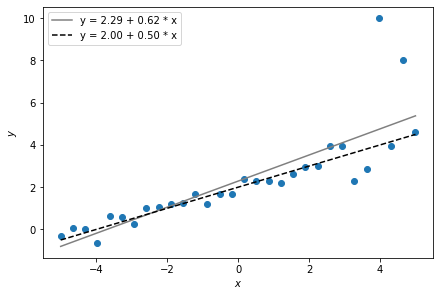

In [8]:
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(data['x'], data['y'])
ax.plot(data['x'],
        trace['mu'].mean(axis=0),
        'gray',
        label=f"y = {trace['beta0'].mean():.2f} + {trace['beta1'].mean():.2f} * x")
ax.plot(data['x'], 
        beta0_true + beta1_true * data['x'],
        'k--',
        label=f'y = {beta0_true:.2f} + {beta1_true:.2f} * x')
        
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend()

リスト8.39: 指数分布におけるパラメータ $\lambda$ の影響



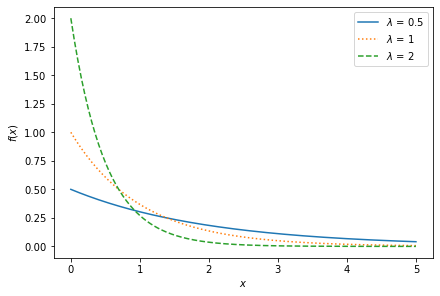

In [45]:
from scipy import stats

x = np.linspace(0, 5, 200)
lams = [0.5, 1, 2]
ls = ['-', ':', '--']

fig, ax = plt.subplots(constrained_layout=True)

for lam, l in zip(lams, ls):
    pdf = stats.expon.pdf(x, scale=1/lam)
    ax.plot(x, pdf, l, label=rf'$\lambda$ = {lam}')
    
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.legend()

リスト8.40: t分布を用いた線形回帰モデルにおけるサンプリング



In [46]:
with pm.Model() as model_t:
    beta0 = pm.Normal('beta0', mu=0, sigma=100)
    beta1 = pm.Normal('beta1', mu=0, sigma=100)
    nu = pm.Exponential('nu', 1/30)
    sigma = pm.HalfNormal('sigma', 5)

    mu = pm.Deterministic('mu', 
                          beta0 + beta1 * data['x'])
    
    pm.StudentT('y', mu=mu, sigma=sigma, nu=nu, 
                observed=data['y'])
    
    trace_t = pm.sample(random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, nu, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.


リスト8.41: 要約統計量の確認



In [47]:
pm.summary(trace_t, var_names='~mu')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,2.013,0.065,1.898,2.150,0.001,0.001,2797.0,2027.0,1.0
beta1,0.455,0.024,0.410,0.501,0.000,0.000,2528.0,2274.0,1.0
nu,1.357,0.509,0.537,2.285,0.011,0.008,1983.0,2421.0,1.0
sigma,0.260,0.084,0.117,0.420,0.002,0.001,1583.0,1732.0,1.0


リスト8.42: 2つのモデルによる回帰直線の比較



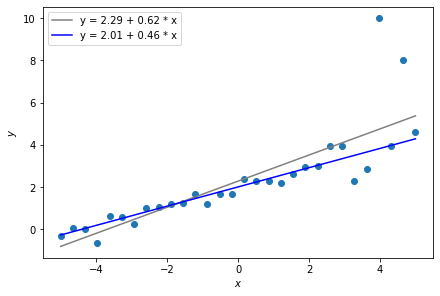

In [48]:
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(data['x'], data['y'])
ax.plot(data['x'], trace['mu'].mean(axis=0), 'gray',
        label=f"y = {trace['beta0'].mean():.2f} + {trace['beta1'].mean():.2f} * x")
ax.plot(data['x'], trace_t['mu'].mean(axis=0), 'b',
        label=f"y = {trace_t['beta0'].mean():.2f} + {trace_t['beta1'].mean():.2f} * x")

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend()

リスト8.43: 回帰直線のHDIを表示



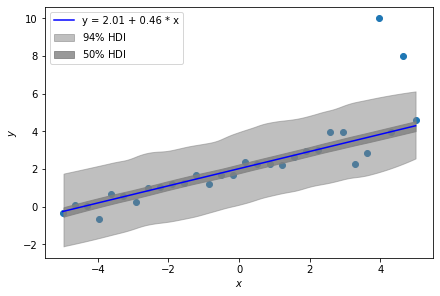

In [49]:
with model_t:
    pp = pm.sample_posterior_predictive(trace_t)

fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(data['x'], data['y'])
ax.plot(data['x'], trace_t['mu'].mean(axis=0), 'b',
        label=f"y = {trace_t['beta0'].mean():.2f} + {trace_t['beta1'].mean():.2f} * x")
        
pm.plot_hdi(data['x'], pp['y'], ax=ax,
            fill_kwargs={'color': 'gray', 
                         'label': r'$94\%$ HDI'})
pm.plot_hdi(data['x'], pp['y'], hdi_prob=0.5, ax=ax,
            fill_kwargs={'color': 'gray', 
                         'alpha': 0.8, 
                         'label': r'$50\%$ HDI'})

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend()

## 8.3 多項式回帰



### 8.3.1 多項式回帰



リスト8.44: データセットの作成



In [50]:
n = 50
beta0_true = 1
beta1_true = 0.1
beta2_true = 0.2

rng = np.random.default_rng(1)
err_x = rng.normal(0, 0.1, size=n)
err_y = rng.normal(0, 0.5, size=n)
x = np.linspace(-5, 5, n) + err_x
y = beta0_true + beta1_true * x + beta2_true * x**2 + err_y

data = {'x': x, 'y': y}

リスト8.45: データの散布図と理論的な2次関数の曲線



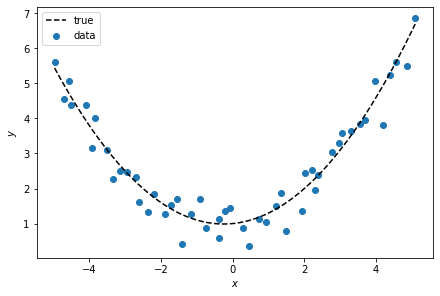

In [51]:
import matplotlib.pyplot as plt

x = np.linspace(data['x'].min(), data['x'].max(), 200)

fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(data['x'], data['y'], label='data')
ax.plot(x, beta0_true + beta1_true * x + beta2_true * x**2, 'k--', label='true')

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend()

リスト8.46: 多項式回帰モデルにおけるサンプリング



In [52]:
with pm.Model() as model_p:
    beta0 = pm.Normal('beta0', mu=0, sigma=100)
    beta1 = pm.Normal('beta1', mu=0, sigma=100)
    beta2 = pm.Normal('beta2', mu=0, sigma=100)
    epsilon = pm.HalfNormal('epsilon', sigma=5)

    mu = pm.Deterministic('mu', beta0 + beta1 * data['x'] + beta2 * data['x']**2)

    pm.Normal('y', mu=mu, sigma=epsilon, 
              observed=data['y'])

    trace_p = pm.sample(random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.


リスト8.47: トレースプロットを表示



array([[<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'beta2'}>,
        <AxesSubplot:title={'center':'beta2'}>],
       [<AxesSubplot:title={'center':'epsilon'}>,
        <AxesSubplot:title={'center':'epsilon'}>]], dtype=object)

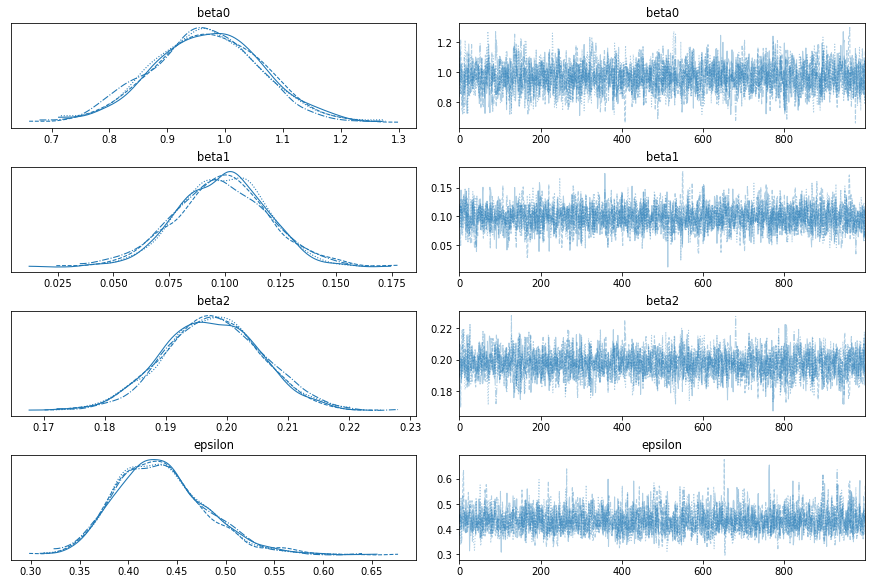

In [53]:
pm.plot_trace(trace_p, var_names='~mu')

リスト8.48: 要約統計量の確認



In [54]:
pm.summary(trace_p, var_names='~mu')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.968,0.094,0.783,1.138,0.002,0.001,2306.0,2387.0,1.0
beta1,0.099,0.021,0.061,0.139,0.000,0.000,3120.0,2670.0,1.0
beta2,0.198,0.008,0.182,0.212,0.000,0.000,2291.0,2458.0,1.0
epsilon,0.434,0.047,0.350,0.517,0.001,0.001,2572.0,2265.0,1.0


リスト8.49: 回帰曲線の描画



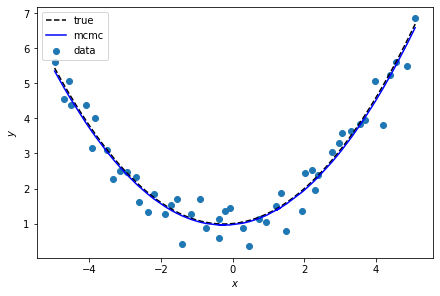

In [55]:
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(data['x'], data['y'], label='data')
ax.plot(x, beta0_true + beta1_true * x + beta2_true * x**2, 'k--', label='true')
ax.plot(data['x'], trace_p['mu'].mean(axis=0), 'b', label='mcmc')

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend()

### 8.3.2 過剰適合



リスト8.50: 多項式の次数を上げると過剰適合が生じる例



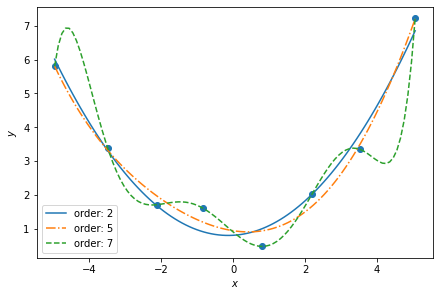

In [56]:
from numpy.polynomial import Polynomial as P

n = 8
beta0_true = 1
beta1_true = 0.1
beta2_true = 0.2

rng = np.random.default_rng(1)
err_x = rng.normal(0, 0.1, size=n)
err_y = rng.normal(0, 1, size=n)
x = np.linspace(-5, 5, n) + err_x
y = beta0_true + beta1_true * x + beta2_true * x**2 + err_y
data = {'x': x, 'y': y}

fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(data['x'], data['y'])

order = [2, 5, 7]
ls = ['-', '-.', '--']
x = np.linspace(data['x'].min(), data['x'].max(), 100)

for i, l in zip(order, ls):
    p = P.fit(data['x'], data['y'], i)
    ax.plot(x, p(x), l, label=f'order: {i}')

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend()